<a href="https://colab.research.google.com/github/kieranfmaguire/learningdeeplearning/blob/main/notebooks/fine_tune_BERT_on_COLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune BERT model on the Corpus of Linguistic Acceptability (COLA) dataset
---
This is a small dataset with only around 10,000 examples. Each example is a single sentence, and a label indicating whether that sentence is grammatically correct or not.

This is one of the many tasks that make up the General Language Understanding Evaluation (GLUE) benchmark often used for assessing the performance of NLP models.

## Plan
---

According to the BERT paper [here](https://arxiv.org/pdf/1810.04805.pdf), to achieve state of the art scores on almost all of the GLUE tasks, they simply fine tuned the model for 3 epochs (scanning a grid of learning rates and selecting the best). This is feasible even on a free GPU on colab (eg here).

To fine tune the model for classification tasks, they add a single dense layer to the end of the model. The input to the classification layer is the embedding corresponding to the special input token `[CLS]`, which can be found at the first position of the sequence outputs of the model. The authors also claim that finetuning just the classification layer still achieved very good results at a lower computational cost. Therefore I will try both methods here. 

To save time, I will only use a single learning rate. `1e-3` for the version where BERT weights are frozen, and `1e-5` when training jointly.

To that end, I will do the following:

1. Use pre-trained BERT with a single classification layer to classify the COLA problem, only training the new layer (do not fine tune entire BERT model).

2. Use pre-trained BERT with single classifications layer to classify, allowing the full BERT model parameters to be fine tuned. 

3. Compare the two models

## NOTES
---
It is best to run this on GPU, otherwise training is painfully slow. On GPU, the training shouldn't take much longer than 15 minutes or so.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
  import tensorflow_text as text
except:
  !pip install -q tensorflow_text # restart runtime if needed to install
  print("Restart runtime to import tensorflow_text")

### Set up parameters
---
 - Note that I am not using the large BERT.
 - Note the name of the dataset is from the list of available datasets [here](https://www.tensorflow.org/datasets/catalog/overview#text)

In [ ]:
# parameters used in the notebook

batch_size = 32               # batch size for fine tuning
data_set_name = 'glue/cola'   # availale from tensorflow_datasets
learning_rate_fast = 1e-3     # for just tuning new layer
learning_rate_slow = 1e-5     # for fine tuning all layes

BERT_URL = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'       # BERT model to use
BERT_PREPROCESS_URL = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1' # Matching preprocess fn


## Load data and so some preprocessing
---
`tensorflow_datasets` contains utilities for collecting common datasets.

There is not much preprocessing required, since BERT comes with an accompanying preprocessor which uses correct vocabulary and tokenising scheme for BERT. It also creates the two extra masks required for training; word masks and sentence masks aka segment id. Since this task involves single sentences only, there is no need to adjust the segment id (we would need to do extra processing for some other tasks involving multiple sentences)


In [ ]:
# load the data using handy tensorflow_datasets package
(cola_train, cola_valid, cola_test), info = tfds.load(data_set_name,                  
                                                      split=['train','validation','test'],
                                                      with_info=True,
                                                      )

In [ ]:
# look at the metadata
print(info)

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.',
    homepage='https://nyu-mll.github.io/CoLA/',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=10657,
    splits={
        'test': 1063,
        'train': 8551,
        'validation': 1043,
    },
    supervised_keys=None,
    citation="""@article{warstadt2018neural,
      title={Neural Network Acceptability Judgments},
      author={Warstadt, Alex and Singh, Amanpreet and Bowman, Samuel R},
      journal={arXiv preprint arXiv:1805.12471},
      year={2018}
    }
    @inproceedings{wang2019glue,
      title={{GLUE}: A Multi-Task Benchmark and Analysis Platfo

In [ ]:
# look at the structure tfds provides the data in
isinstance(cola_train, tf.data.Dataset)
for example in cola_train.take(1):
  print(example['sentence'])
  print(example['label'])

tf.Tensor(b'It is this hat that it is certain that he was wearing.', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
# minimal preprocessing - just extract the sentence and the label, shuffle, batch and prefetch
cola_train = cola_train.map(lambda x: (x['sentence'], x['label']))\
  .shuffle(int(1e3))\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)
cola_valid = cola_valid.map(lambda x: (x['sentence'], x['label']))\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)
cola_test = cola_test.map(lambda x: (x['sentence'], x['label']))\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)

# have a look to make sure it looks okay
for ex in cola_train.take(1):
  print(ex)


(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'The jeweller printed the name over the door.',
       b'the girls likes themselves.', b'Sincerity examined a book.',
       b'The well gushed oil.', b'We contributed her with our paycheck.',
       b'Gilgamesh cut the steak with a knife.',
       b"I know I should go to the dentist's, but I just don't want to.",
       b'The horse kicked Penny in the shin.',
       b'I ordered that John drink his beer.',
       b'The gentleman who saved Marianne was Willoughby.',
       b'We ate enough the puddings to satisfy us.',
       b'What happened was they knew his parents.',
       b'The children like to berry in the summer.',
       b'John seems to have left.',
       b'They gave my father, who had just turned 60, it.',
       b'Nora sent the book to London.',
       b'If Jim feels good, he will go.',
       b'The box contained the ball to the ground.',
       b'That I should evaporate is my fondest dream',
       b'Who thought up the pro

## Load the BERT model and create our model for classification
---
The pre-trained model contains ~100M weights, so it will take a couple of minutes to load.

Load BERT and matching preprocessor into a `KerasLayer`, which is the preferred way to load models from tensorflow hub when using the higher level API. For lower level control, use `.load()`

After that, specify the model using the functional API, and compile. We will train it using cross entropy loss: 

$L(y, \hat{y_i}) = \frac{1}{n}\sum_{i=1}^n \,\, - y_i \ln{(\hat{y_i})} - 
(1 - y_i) \ln{(1 - \hat{y_i})}$

Where the $i$ indicates the $i^{th}$ element of the batch. Clearly if correct value is 1, then the loss will be large if $\hat{y}$ is small, and vice versa for the negative class.

The official [GLUE](https://gluebenchmark.com/tasks) benchmarks reports Matthew's Correlation ([wikipedia](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient#:~:text=The%20Matthews%20correlation%20coefficient%20\(MCC,Matthews%20in%201975)), so I also record that value. There is a library function to do so available in `tensorflow_addons`, however it doesn't seem to work correctly, as the value never changes. I haven't looked into it yet - possibly my syntax is just incorrect or something.

EDIT: After investigating source code of `tensorflow_addons.metrics.MatthewsCorrelationCoefficient`, I can see it assumed predictions are input in binary form, not probabilities. But this is not what is passed to the metric during training, so it is not useful to view during training. F1-score on the other hand provides an optional argument "threshold" which will be used to convert probabilities to classes.

SOLUTION: For now, create custom MCC metric. Use instead of the version provided by `tfa`


In [ ]:
# load the BERT model and BERT preprocessor. Use the model which cares about upper/lower case
bert = hub.KerasLayer(BERT_URL, name='BERT', trainable=False)
prep = hub.KerasLayer(BERT_PREPROCESS_URL, name='BERT_PREPROCESSOR', trainable=False)

In [ ]:
# create a custom metric to view the MCC score 

class MCC(tf.keras.metrics.Metric):
  def __init__(self, name='MCC', **kwargs):
    super().__init__(**kwargs)
    self.tp = self.add_weight('true_positives', initializer='zeros')
    self.tn = self.add_weight('true_negatives', initializer='zeros')
    self.fp = self.add_weight('false_positives', initializer='zeros')
    self.fn = self.add_weight('false_negatives', initializer='zeros')
  def update_state(self, labels, preds, sample_weight=None):
    preds_class = tf.math.round(preds)
    tp = tf.reduce_sum(tf.where((preds_class == 1) & (labels == 1), 1., 0.))
    tn = tf.reduce_sum(tf.where((preds_class == 0) & (labels == 0), 1., 0.))
    fp = tf.reduce_sum(tf.where((preds_class == 1) & (labels == 0), 1., 0.))
    fn = tf.reduce_sum(tf.where((preds_class == 0) & (labels == 1), 1., 0.))
    self.tp.assign_add(tp)
    self.tn.assign_add(tn)
    self.fp.assign_add(fp)
    self.fn.assign_add(fn)
  def result(self):
    numer = (self.tp * self.tn) - (self.fp * self.fn)
    denom = tf.math.sqrt((self.tp + self.fp) * (self.tp + self.fn) * (self.tn + self.fp) * (self.tn + self.fn))
    return tf.math.divide_no_nan(numer, denom)


In [ ]:
# create the model using functional API
def create_model_1():
  bert.trainable = False
  prep.trainable = False
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
  preprocessed_text = prep(text_input)
  bert_out = bert(preprocessed_text)
  cls_token_out = bert_out['sequence_output'][:,0,:]
  drop = tf.keras.layers.Dropout(0.3)(cls_token_out)
  out = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output')(drop)

  return tf.keras.Model(inputs=[text_input], outputs=[out])

m1 = create_model_1()
m1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fast),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=['accuracy', 'AUC', tfa.metrics.F1Score(num_classes=1, threshold=0.5), MCC()])
m1.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
BERT_PREPROCESSOR (KerasLayer)  {'input_word_ids': ( 0           text_input[0][0]                 
__________________________________________________________________________________________________
BERT (KerasLayer)               {'encoder_outputs':  109482241   BERT_PREPROCESSOR[1][0]          
                                                                 BERT_PREPROCESSOR[1][1]          
                                                                 BERT_PREPROCESSOR[1][2]          
_______________________________________________________________________________________

## Train the model with BERT weights frozen

In [ ]:
history1 = m1.fit(cola_train, epochs=3, validation_data=cola_valid)

Epoch 1/3
268/268 [==============================] - 99s 370ms/step - loss: 0.5936 - accuracy: 0.7011 - auc: 0.6229 - f1_score: 0.8161 - mcc_1: 0.1175 - val_loss: 0.5360 - val_accuracy: 0.7430 - val_auc: 0.7562 - val_f1_score: 0.8391 - val_mcc_1: 0.3254
Epoch 2/3
268/268 [==============================] - 97s 360ms/step - loss: 0.5383 - accuracy: 0.7398 - auc: 0.7222 - f1_score: 0.8364 - mcc_1: 0.2827 - val_loss: 0.5165 - val_accuracy: 0.7478 - val_auc: 0.7747 - val_f1_score: 0.8415 - val_mcc_1: 0.3420
Epoch 3/3
268/268 [==============================] - 97s 360ms/step - loss: 0.5275 - accuracy: 0.7467 - auc: 0.7374 - f1_score: 0.8390 - mcc_1: 0.3114 - val_loss: 0.5071 - val_accuracy: 0.7689 - val_auc: 0.7848 - val_f1_score: 0.8506 - val_mcc_1: 0.4092


### **Verify that custom MCC matches library version only after predictions are converted from probabilities to classes**


In [ ]:
# these preds are still in form of probabilities
preds = m1.predict(cola_valid)
labels_valid = []
for _, lab in cola_valid.as_numpy_iterator():
  labels_valid += lab.tolist()
labels_valid = np.array(labels_valid).reshape(-1,1)

In [ ]:
mcc1 = MCC()
mcc2 = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=1)
mcc1.update_state(labels_valid, preds)
mcc2.update_state(labels_valid, preds)
# can see the results are different
mcc1.result(), mcc2.result()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.40923062>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5879095], dtype=float32)>)

In [ ]:
# now convert preds to classes and compute the two metrics again
preds_ = tf.math.round(preds)
mcc1 = MCC()
mcc2 = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=1)
mcc1.update_state(labels_valid, preds_)
mcc2.update_state(labels_valid, preds_)
# the numbers match now - we can trust the custom MCC score
mcc1.result(), mcc2.result()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.40923062>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.40923062], dtype=float32)>)

## Create and train the second model, where BERT weights are not frozen

In [ ]:
# RE-load the BERT model (reset weights)
bert = hub.KerasLayer(BERT_URL, name='BERT', trainable=True)


In [ ]:
# now what if we allow all weights in the model to be fine tunes
def create_model_2():
  bert.trainable = True
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
  preprocessed_text = prep(text_input)
  bert_out = bert(preprocessed_text)
  cls_token_out = tf.keras.layers.Lambda(
      lambda x: x['sequence_output'][:,0,:], name='get_cls_embedding')(bert_out)
  drop = tf.keras.layers.Dropout(0.3)(cls_token_out)
  out = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output')(drop)

  return tf.keras.Model(inputs=[text_input], outputs=[out])

m2 = create_model_2()
m2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_slow),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=['accuracy', 'AUC', tfa.metrics.F1Score(num_classes=1, threshold=0.5), MCC()])
m2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
BERT_PREPROCESSOR (KerasLayer)  {'input_word_ids': ( 0           text_input[0][0]                 
__________________________________________________________________________________________________
BERT (KerasLayer)               {'encoder_outputs':  109482241   BERT_PREPROCESSOR[2][0]          
                                                                 BERT_PREPROCESSOR[2][1]          
                                                                 BERT_PREPROCESSOR[2][2]          
_______________________________________________________________________________________

In [ ]:
history2 = m2.fit(cola_train, epochs=3, validation_data=cola_valid)

Epoch 1/3
268/268 [==============================] - 244s 909ms/step - loss: 0.5363 - accuracy: 0.7390 - auc: 0.7302 - f1_score: 0.8298 - mcc_4: 0.3039 - val_loss: 0.4540 - val_accuracy: 0.7967 - val_auc: 0.8567 - val_f1_score: 0.8667 - val_mcc_4: 0.4914
Epoch 2/3
268/268 [==============================] - 244s 912ms/step - loss: 0.3494 - accuracy: 0.8494 - auc: 0.9040 - f1_score: 0.8954 - mcc_4: 0.6288 - val_loss: 0.4888 - val_accuracy: 0.8111 - val_auc: 0.8797 - val_f1_score: 0.8743 - val_mcc_4: 0.5312
Epoch 3/3
268/268 [==============================] - 244s 911ms/step - loss: 0.2356 - accuracy: 0.9054 - auc: 0.9565 - f1_score: 0.9336 - mcc_4: 0.7698 - val_loss: 0.5074 - val_accuracy: 0.8255 - val_auc: 0.8728 - val_f1_score: 0.8793 - val_mcc_4: 0.5737


## Compare the results for first two models on validation set

In [ ]:
hist_1 = pd.DataFrame(history1.history)
hist_2 = pd.DataFrame(history2.history)
hist = hist_1.join(hist_2, lsuffix='_freeze_bert')
hist = hist.applymap(lambda x: x[0] if isinstance(x, np.ndarray) else x)

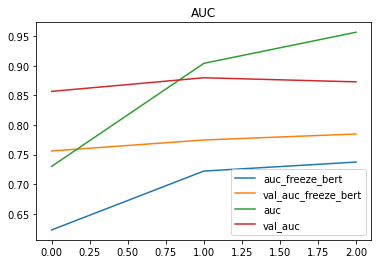

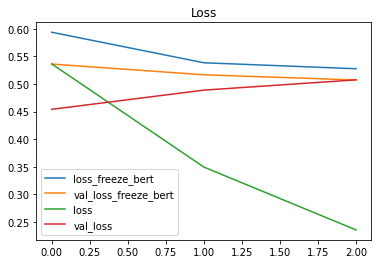

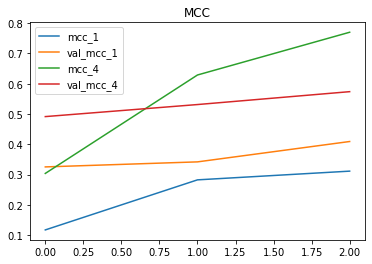

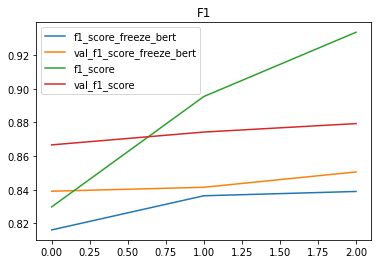

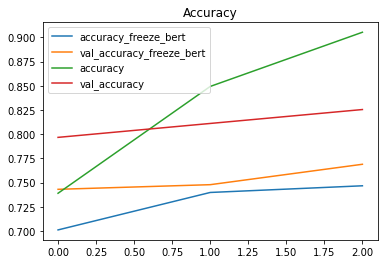

In [ ]:
# compare the validation loss, accuracy and AUC for the two models
hist.loc[:, [x for x in hist.columns if (x.startswith('val_auc') | x.startswith('auc'))]].plot(title='AUC')
hist.loc[:, [x for x in hist.columns if (x.startswith('val_loss') | x.startswith('loss'))]].plot(title="Loss")
hist.loc[:, [x for x in hist.columns if (x.startswith('val_mcc') | x.startswith('mcc'))]].plot(title="MCC")
hist.loc[:, [x for x in hist.columns if (x.startswith('val_f1') | x.startswith('f1'))]].plot(title="F1")
hist.loc[:, [x for x in hist.columns if (x.startswith('val_acc') | x.startswith('acc'))]].plot(title="Accuracy")

Looks like you would choose the fully tuned model based on all metrics except for loss, where it is a tie.

I guess this means the freeze bert model is just being more confident in one of the two classes to get the loss score up, but not so good at selecting the bad grammar sentences? Should create a confusion matrix to understand better.

The dataset is not balanced, so be careful when looking at accuracy. (see below)





## Main Observation

**The Matthews Correlation is no where near the number claimed in the paper (although note the value published is for the test set). Need to look into why the performance is not comparable**

Maybe I should use the pooling output instead of the classification output? It is possible the classification output is only relevant to the two sentance classification task. Need to revisit this.


In [ ]:
# check out the balance of the dataset 
labels = []
for _, lab in cola_train.as_numpy_iterator():
    labels += lab.tolist()
labels = pd.DataFrame(labels, columns=['label'])
(labels == 1).sum().values / labels.shape[0], (labels == 0).sum().values / labels.shape[0]

(array([0.70436206]), array([0.29563794]))

In [ ]:
labels_valid = []
for _, lab in cola_valid.as_numpy_iterator():
  labels_valid += lab.tolist()

predictions_freeze_bert = m1.predict(cola_valid) 
predictions_full = m2.predict(cola_valid)


In [ ]:
confusion_freeze_bert = tf.math.confusion_matrix(
    labels_valid, np.rint(predictions_freeze_bert), dtype=tf.dtypes.int32,
)


# true labels are rows
# predicted labels are columns

confusion_freeze_bert



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[116, 206],
       [ 35, 686]], dtype=int32)>

In [ ]:
class_0_actual = confusion_freeze_bert.numpy()[0,:].sum()
class_0_prediction = confusion_freeze_bert.numpy()[:,0].sum()
class_1_actual = confusion_freeze_bert.numpy()[1,:].sum()
class_1_prediction = confusion_freeze_bert.numpy()[:,1].sum()

accuracy = np.diag(confusion_freeze_bert).sum() / confusion_freeze_bert.numpy().sum()

In [ ]:
accuracy

0.7689357622243528